# Probabilistic Programming using PyMC, and Graphical Models

Today, we shall discuss the following two topics:

1. Probabilistic Programming using PyMC
2. Graphical Models 

Practical Bayesian Inference is often carried out through specialized probabilistic programming libraries such as PyMC. In these libraries, one inputs the probability model (prior and likelihood) and obtains an output of the posterior distributions in the form of Monte Carlo samples. The outputted Monte Carlo samples provide an approximation of the posterior distributions.

To illustrate probabilistic programming with PyMC, consider the following simple probability model. We have four binary random variables: overweight, smoking, heart disease and cough. Suppose we specify a probability model for these random variables as:
\begin{align*}
   & \text{overweight} \sim \text{Bernoulli}(0.1) \\
   & \text{smoking} \sim \text{Bernoulli}(0.1) \\
   & \text{heart disease} \mid \text{overweight} = 1, \text{smoking} = 1 \sim \text{Bernoulli}(0.75) \\
   & \text{heart disease} \mid \text{overweight} = 1, \text{smoking} = 0 \sim \text{Bernoulli}(0.5) \\
   & \text{heart disease} \mid \text{overweight} = 0, \text{smoking} = 1 \sim \text{Bernoulli}(0.4) \\
   & \text{heart disease} \mid \text{overweight} = 0, \text{smoking} = 0 \sim \text{Bernoulli}(0.1) \\
   & \text{cough} \mid \text{smoking} = 1 \sim \text{Bernoulli}(0.6) \\
   & \text{cough} \mid \text{smoking} = 0 \sim \text{Bernoulli}(0.05)
\end{align*}
The above model starts by specifying the marginal distribution of overweight and smoking. Then it specifies the conditional distribution of heart disease conditional on overweight and smoking. Finally, it specifies the conditional distribution of cough conditional on smoking. Based on this model, we might be interested in several probability questions such as:
1. What is the marginal distribution of heart disease i.e., $\mathbb{P}(\text{heart disease} = 1)$?
2. What is the conditional distribution of overweight conditional on heart disease i.e., $\mathbb{P}(\text{overweight} = 1 \mid \text{heart disease} = 1)$?
3. What is conditional distribution of smoking conditional on cough i.e., $\mathbb{P}(\text{smoking} = 1 \mid \text{cough} = 1)$?

All these probabilities can be calculated exactly using the model specification. One way of doing this is to note that for every binary $b_o, b_s, b_h, b_c \in \{0, 1\}$, we can write
\begin{align*}
  &\mathbb{P}\left(\text{overweight} = b_o, \text{smoking} = b_s, \text{heart} = b_h, \text{cough} = b_c \right) \\
  &= \mathbb{P}\left(\text{overweight} = b_o \right) \mathbb{P}\left(\text{smoking} = b_s \right) \mathbb{P} \left(\text{heart} = b_h \mid \text{overweight} = b_o, \text{smoking} = b_s \right) \mathbb{P} \left(\text{cough} = b_c \mid \text{smoking} = b_s \right)
\end{align*}
and these probabilities can then be read off from the model specification. For example, with $b_o = b_s = b_h = b_c = 1$, we get
\begin{align*}
    &\mathbb{P}\left(\text{overweight} = 1, \text{smoking} = 1, \text{heart} = 1, \text{cough} = 1 \right) \\
    &= \mathbb{P}\left(\text{overweight} = 1 \right) \mathbb{P}\left(\text{smoking} = 1 \right) \mathbb{P} \left(\text{heart} = 1 \mid \text{overweight} = 1, \text{smoking} = 1 \right) \mathbb{P} \left(\text{cough} = 1 \mid \text{smoking} = 1 \right) \\
    &= 0.1 \times 0.1 \times 0.75 \times 0.6
\end{align*}
From the full joint distribution of the four variables, all the probabilities asked in the questions can be calculated. 

It is clear that this approach will be quite tedious especially if we are dealing with more than four random variables. Probabilistic Programming Libraries (such as PyMC) automate the calculation of these probabilities. However, instead of calculating probabilities exactly, they output "samples" from which probabilities can be approximated. Here is how this works for this simple health probability model.

In [1]:
#Import the necessary libraries:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm #pymc3 is the previous version of pymc. We shall switch to pymc as soon as it gets installed in datahub

ModuleNotFoundError: No module named 'pymc3'

In [4]:
from graphviz import Digraph

ModuleNotFoundError: No module named 'graphviz'

In [2]:
#Specify the Model in PyMC: 
health_model = pm.Model()
with health_model:
    
    overweight = pm.Bernoulli('overweight', 0.1)
    smoking = pm.Bernoulli('smoking', 0.1)
    # Deterministic probabilities for 'heart' based on conditions
    p_heart = pm.Deterministic('p_heart', pm.math.switch(overweight, 
                                      pm.math.switch(smoking, 0.75, 0.5), 
                                      pm.math.switch(smoking, 0.4, 0.1)))

    # 'heart' random variable
    heart = pm.Bernoulli('heart', p_heart)
    # Deterministic probability for 'cough' based on 'smoking'
    p_cough = pm.Deterministic('p_cough', pm.math.switch(smoking, 0.6, 0.05))
    # 'cough' random variable
    cough = pm.Bernoulli('cough', p_cough)
    #This ends the specification of the model. 
    #To obtain samples from PyMC, run the following:
    idata = pm.sample(5000, chains = 4, return_inferencedata = True)
    #This will generate 5000*4 = 20000 posterior samples from (overweight, smoking, heart, cough).

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [overweight, smoking, heart, cough]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [3]:
print(idata.posterior)
overweight_samples = idata.posterior['overweight'].values.flatten()
smoking_samples = idata.posterior['smoking'].values.flatten()
heart_samples = idata.posterior['heart'].values.flatten()
cough_samples = idata.posterior['cough'].values.flatten()
all_samples = np.column_stack((overweight_samples, smoking_samples, heart_samples, cough_samples))
print(all_samples[:80])

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 5000)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
Data variables:
    overweight  (chain, draw) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    smoking     (chain, draw) int64 0 0 0 0 0 0 0 0 0 0 ... 0 1 1 0 0 0 0 0 0 0
    heart       (chain, draw) int64 0 0 0 0 0 0 0 0 0 0 ... 0 1 0 1 0 0 0 0 0 0
    cough       (chain, draw) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 1 0 0 0 0 0 0 0
    p_heart     (chain, draw) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    p_cough     (chain, draw) float64 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05
Attributes:
    created_at:                 2023-09-19T23:03:00.075509
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              5.032527685165405
    tuning_steps:               1000
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0

With these samples, the questions we posed previously can be answered. For example, the marginal distribution of heart disease can be calculated as:

In [4]:
#Marginal probability that heart = 1:
print(np.sum(heart_samples)/len(heart_samples))

#This should be compared to the actual value of the probability which can be calculated (more tediously) as:
p_overweight = 0.1
p_smoking = 0.1
# Conditional probabilities for heart
p_heart_given_overweight_and_smoking = 0.75
p_heart_given_overweight_and_not_smoking = 0.5
p_heart_given_not_overweight_and_smoking = 0.4
p_heart_given_not_overweight_and_not_smoking = 0.1
# Calculate the marginal probability of heart being 1
p_heart = (
    p_overweight * p_smoking * p_heart_given_overweight_and_smoking +
    p_overweight * (1 - p_smoking) * p_heart_given_overweight_and_not_smoking +
    (1 - p_overweight) * p_smoking * p_heart_given_not_overweight_and_smoking +
    (1 - p_overweight) * (1 - p_smoking) * p_heart_given_not_overweight_and_not_smoking
)
print(p_heart)

0.1631
0.16950000000000004


The second question asked to calculate the conditional distribution of overweight conditional on heart disease i.e., $\mathbb{P}(\text{overweight} = 1 \mid \text{heart disease} = 1)$? We can again calculate this using the previous samples in the following. We only consider those samples for which heart = 1. Then we calculate the proportion of these samples where overweight also equals 1. This can be done as follows:

In [5]:
#Calculating the conditional probability of overweight = 1 given heart = 1 from the posterior samples.
mask = (heart_samples == 1)
print(sum(mask)) #this means that many of the original samples are discarded for this calculation.
count_overweight_given_heart = sum(overweight_samples[mask] == 1)
required_probability = count_overweight_given_heart/sum(mask)
print(required_probability)

#Exact calculation
print((p_overweight * p_smoking * p_heart_given_overweight_and_smoking + p_overweight * (1 - p_smoking) * p_heart_given_overweight_and_not_smoking) / p_heart)

3262
0.30257510729613735
0.30973451327433627


Thus even though we had 20000 posterior samples to begin with, only about 3200 of them have heart disease equal to 1. This means that this probability is approximated based on only 3200 samples (as opposed to 20000). In PyMC, if you want to generate samples conditional on certain values (such as $\text{heart disease} = 1$ in the above example), one plugs this information into the model at the specification stage. This prevents the wastage of samples as above. This is illustrated below.

In [6]:
#PyMC model when heart is pre-specified as 1. 
health_model_1 = pm.Model()
with health_model_1:
    overweight = pm.Bernoulli('overweight', 0.1)
    smoking = pm.Bernoulli('smoking', 0.1)
    # Deterministic probabilities for 'heart' based on conditions
    p_heart = pm.Deterministic('p_heart', pm.math.switch(overweight, 
                                      pm.math.switch(smoking, 0.75, 0.5), 
                                      pm.math.switch(smoking, 0.4, 0.1)))

    # 'heart' random variable
    heart = pm.Bernoulli('heart', p_heart, observed = 1) 
    #observed = 1 means we want heart to be fixed at the observed value of 1.
    #If we want heart to be fixed at 0, we would say observed = 0.
    # Deterministic probability for 'cough' based on 'smoking'
    p_cough = pm.Deterministic('p_cough', pm.math.switch(smoking, 0.6, 0.05))
    # 'cough' random variable
    cough = pm.Bernoulli('cough', p_cough)
    #This ends the specification of the model. 
    #To obtain samples from PyMC, run the following:
    idata = pm.sample(5000, chains = 4, return_inferencedata = True)
    #This will generate 5000*4 = 20000 posterior samples from (overweight, smoking, heart, cough).

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [overweight, smoking, cough]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


In [7]:
print(idata.posterior)
overweight_samples = idata.posterior['overweight'].values.flatten()
smoking_samples = idata.posterior['smoking'].values.flatten()
cough_samples = idata.posterior['cough'].values.flatten()
all_samples = np.column_stack((overweight_samples, smoking_samples, cough_samples))
print(all_samples[:80])

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 5000)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
Data variables:
    overweight  (chain, draw) int64 1 0 1 0 1 0 0 0 0 1 ... 0 0 0 0 0 0 0 1 1 0
    smoking     (chain, draw) int64 0 0 0 0 0 0 0 0 0 0 ... 1 1 0 0 0 0 0 0 0 0
    cough       (chain, draw) int64 0 0 0 0 0 0 0 0 0 0 ... 1 0 0 0 0 0 0 0 0 0
    p_heart     (chain, draw) float64 0.5 0.1 0.5 0.1 0.5 ... 0.1 0.5 0.5 0.1
    p_cough     (chain, draw) float64 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05
Attributes:
    created_at:                 2023-09-19T23:11:52.450208
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              4.087341785430908
    tuning_steps:               1000
[[1 0 0]
 [0 0 0]
 [1 0 0]
 [0 0 0]
 [1 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 0]
 [1 0 0]
 [1 0 0]
 [0 0

With these samples (conditioned on $\text{heart} = 1$), we can calculate the conditional probability of overweight given heart disease as:

In [8]:
#Marginal probability that heart = 1:
print(np.sum(overweight_samples)/len(overweight_samples))

0.31235


For the third question, we need to calculate the conditional distribution of smoking conditional on cough i.e.,  $\mathbb{P}(\text{smoking}=1∣\text{cough}=1)$. This can be again be done by insisting on $\text{cough} = 1$ in the PyMC model specification as follows.

In [9]:
#PyMC model when cough is pre-specified as 1. 
health_model_2 = pm.Model()
with health_model_2:
    overweight = pm.Bernoulli('overweight', 0.1)
    smoking = pm.Bernoulli('smoking', 0.1)
    # Deterministic probabilities for 'heart' based on conditions
    p_heart = pm.Deterministic('p_heart', pm.math.switch(overweight, 
                                      pm.math.switch(smoking, 0.75, 0.5), 
                                      pm.math.switch(smoking, 0.4, 0.1)))

    # 'heart' random variable
    heart = pm.Bernoulli('heart', p_heart) 
    #observed = 1 means we want heart to be fixed at the observed value of 1.
    #If we want heart to be fixed at 0, we would say observed = 0.
    # Deterministic probability for 'cough' based on 'smoking'
    p_cough = pm.Deterministic('p_cough', pm.math.switch(smoking, 0.6, 0.05))
    # 'cough' random variable
    cough = pm.Bernoulli('cough', p_cough, observed = 1)
    #This ends the specification of the model. 
    #To obtain samples from PyMC, run the following:
    idata = pm.sample(5000, chains = 4, return_inferencedata = True)
    #This will generate 5000*4 = 20000 posterior samples from (overweight, smoking, heart, cough).

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [overweight, smoking, heart]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


In [10]:
print(idata.posterior)
overweight_samples = idata.posterior['overweight'].values.flatten()
smoking_samples = idata.posterior['smoking'].values.flatten()
heart_samples = idata.posterior['heart'].values.flatten()
all_samples = np.column_stack((overweight_samples, smoking_samples, heart_samples))
#Required conditional probability:
print(np.sum(smoking_samples)/len(smoking_samples))

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 5000)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
Data variables:
    overweight  (chain, draw) int64 0 0 0 0 0 0 0 0 0 0 ... 0 1 1 1 0 0 0 0 0 0
    smoking     (chain, draw) int64 1 0 0 1 0 1 1 1 1 0 ... 1 1 1 0 1 0 1 0 1 0
    heart       (chain, draw) int64 0 0 1 0 0 0 1 0 1 0 ... 0 1 0 1 1 0 0 0 0 0
    p_heart     (chain, draw) float64 0.4 0.1 0.1 0.4 0.1 ... 0.4 0.1 0.4 0.1
    p_cough     (chain, draw) float64 0.6 0.05 0.05 0.6 ... 0.6 0.05 0.6 0.05
Attributes:
    created_at:                 2023-09-19T23:13:30.935572
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              4.06363320350647
    tuning_steps:               1000
0.56815


## Graphical Models

It is often convenient to represent Bayesian probability models in the form of **Graphical Models**. Graphical Models are graphical representations of probability models. Each random variable in the model is represented by a circle (sometimes random variables whose values are observed are shaded). A directed edge is put from edge $w$ to edge $v$ if the distribution of $v$ in the model is described in terms of $w$. 

Graphical models should be constructed sequentially in the same order as the variables appear in the PyMC specification. For example, in this health model, the following steps should be followed in sequence to form the graphical model:
1. The first random variable in the PyMC model specification is "overweight". So we first draw a node (circle) for this random variable. At this stage, the graphical model only consists of a single node (overweight) 
2. The second variable is "smoking" so we draw a node (circle) for smoking. The probability specification for smoking does not involve the first variable overweight so we do not place any edge from overweight to smoking. At this stage, the graphical model only consists of two nodes (overweight and smoking) without any edge between them. 
3. The third variable is "heart disease" so we draw a node (circle) for heart disease. The probability specification for heart disease clearly uses both overweight and smoking so we place two directed edges: one from overweight to heart, and the other from smoking to heart. 
4. The fourth variable is "cough" so we draw a node for cough. The probability specification for cough clearly uses smoking (and not overweight or heart disease) so we play one directed edge from smoking to heart. 

This graphical model can be drawn in Python as follows:

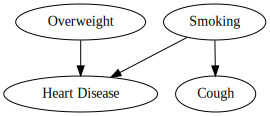

In [11]:
from graphviz import Digraph
def create_graphical_model():
    # Create a new directed graph
    dot = Digraph()

    # Add nodes
    dot.node('overweight', 'Overweight')
    dot.node('smoking', 'Smoking')
    dot.node('heart_disease', 'Heart Disease')
    dot.node('cough', 'Cough')
    
    # Add edges
    dot.edge('overweight', 'heart_disease')
    dot.edge('smoking', 'heart_disease')
    dot.edge('smoking', 'cough')

    return dot

# Display the graph
display(create_graphical_model())

Graphical models are useful because interesting (conditional) independence facts can be simply read off from them. The language of familial relationships is extremely useful when discussing graphical models. For example, in the above graphical model, we can use the following terminology: 
1. Overweight and Smoking variables can be seen as "founders" of this family of variables. 
2. Heart disease is child born to parents overweight and smoking.
3. Cough is a child born to Smoking. 

The conditional independence relationships induced by graphical models exactly match those found in simple Mendelian genetics. For example, in the above graphical model: 
1. Overweight and Smoking are marginally independent
2. Conditional on the parents (overweight and smoking), the children (heart disease and cough) are independent. 
3. Without conditioning on parents, heart disease and cough are **not** independent. Knowing something about heart disease will change what we think about cough. 
4. Conditional on smoking, the two children heart disease and cough are independent. 
5. Cough and Overweight are marginally independent. 

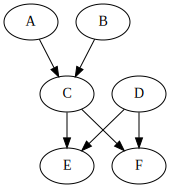

In [12]:
#Another Graphical Model:
from graphviz import Digraph

# Create a directed graph
dot = Digraph()

# Add nodes to the graph
for node in ['A', 'B', 'C', 'D', 'E', 'F']:
    dot.node(node)

# Add directed edges
edges = [('A', 'C'), ('B', 'C'), ('C', 'E'), ('D', 'E'), ('C', 'F'), ('D', 'F')]
for edge in edges:
    dot.edge(edge[0], edge[1])

# Display the graph in the Jupyter notebook
display(dot)

In [2]:
from graphviz import Digraph

ModuleNotFoundError: No module named 'graphviz'

Here are some conditional independence relationships induced by this graphical model:
1. A, B, D are marginally independent. 
2. E and F are conditionally independent given C and D. 
3. C and D are marginally independent. 
4. C and D are **not** conditionally independent given E.
5. A and B are **not** conditionally independent given E.

# Bayesian Statistics using PyMC

Next we revisit the simple examples that we studied in the previous two lectures. We shall use PyMC to answer questions based on these models. We shall also draw the graphical models associated with these models. 

## Microwave Example using PyMC

In the Microwave Example, there are two parameters: $\theta_A$ and $\theta_B$ representing the qualities of the two microwaves. The data for Microwave A is given by 3 out of 3 positive reviews: $\text{pos}_A = 3, n_A = 3$ ($n_A$ is the total number of reviews for A). The data for Microwave B is given by 19 out of 20 positive reviews: $\text{pos}_B = 19$, $n_B = 20$.

In [14]:
#Data
pos_A_obs = 3
neg_A_obs = 0
n_A_obs = 3
pos_B_obs = 19
neg_B_obs = 1
n_B_obs = 20

The prior is given by $\theta_A, \theta_B \overset{\text{i.i.d}}{\sim} \text{uniform}[0, 1]$ and the likelihood is $\text{pos}_A \mid \theta_A \sim \text{Bin}(n_A, \theta_A)$ and $\text{pos}_B \mid \theta_B \sim \text{Bin}(n_B, \theta_B)$. We can input this Bayesian model in PyMC as follows:

In [15]:
#PyMC Model:
microwave_model = pm.Model()
with microwave_model:
    #Priors
    theta_A = pm.Beta("theta_A", alpha=1, beta=1)
    theta_B = pm.Beta("theta_B", alpha=1, beta=1)
    #Likelihoods
    pos_A = pm.Binomial("pos_A", n=n_A_obs, p=theta_A, observed = pos_A_obs)
    pos_B = pm.Binomial("pos_B", n=n_B_obs, p=theta_B, observed = pos_B_obs)
    #Sample from posterior:
    idata = pm.sample(5000, chains = 4, return_inferencedata = True) 
    #The above step is asking for 5000*4 = 20000 posterior samples of theta_A and theta_B

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_B, theta_A]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.


In [16]:
#We can access the posterior samples in the following way:
theta_A_samples = idata.posterior['theta_A'].values.flatten()
display(len(theta_A_samples))
display(theta_A_samples)
theta_B_samples = idata.posterior['theta_B'].values.flatten()
display(len(theta_B_samples))
display(theta_B_samples)

20000

array([0.75401301, 0.9005176 , 0.79450101, ..., 0.89130518, 0.90965358,
       0.83777861])

20000

array([0.98174034, 0.94598862, 0.9778023 , ..., 0.951163  , 0.95447991,
       0.78704502])

We saw in Lecture Six that the correct posterior for $\theta_A$ is $\text{Beta}(4, 1)$
Also the correct posterior for $\theta_B$ is $\text{Beta}(20, 2)$. We can check if the
samples generated above correctly approximate the correct posteriors as follows. 

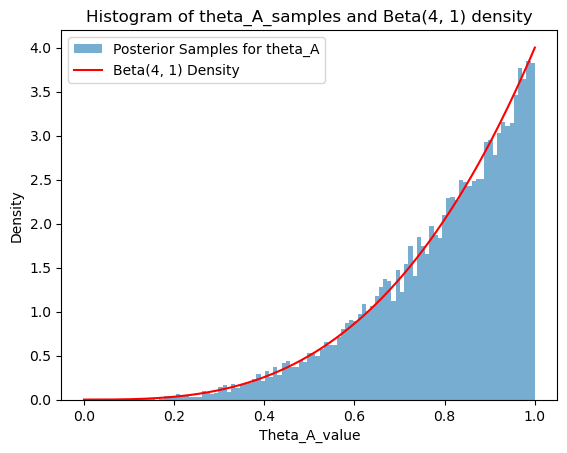

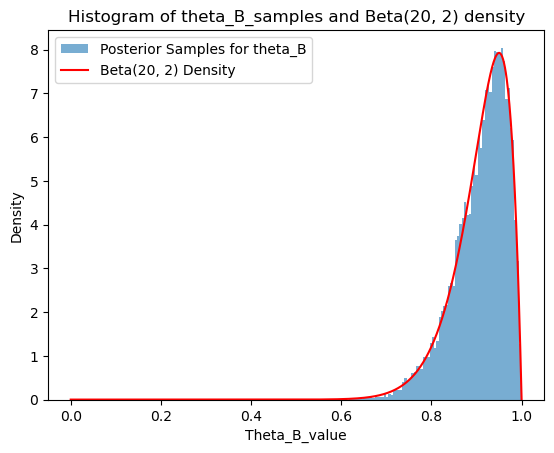

In [17]:
from scipy.stats import beta
plt.hist(theta_A_samples, bins = 100, density = True, alpha = 0.6, label = 'Posterior Samples for theta_A') #alpha controls the opacity of the plotted histogram bars 
#alpha = 1 is completely opaque and alpha = 0 is completely transparent
x = np.linspace(0, 1, 1000)
pdf_values = beta.pdf(x, pos_A_obs + 1, neg_A_obs + 1)
plt.plot(x, pdf_values, 'r-', label = 'Beta(4, 1) Density')
plt.xlabel('Theta_A_value')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of theta_A_samples and Beta(4, 1) density')
plt.show()

plt.hist(theta_B_samples, bins = 100, density = True, alpha = 0.6, label = 'Posterior Samples for theta_B') #alpha controls the opacity of the plotted histogram bars 
#alpha = 1 is completely opaque and alpha = 0 is completely transparent
x = np.linspace(0, 1, 1000)
pdf_values = beta.pdf(x, pos_B_obs + 1, neg_B_obs + 1)
plt.plot(x, pdf_values, 'r-', label = 'Beta(20, 2) Density')
plt.xlabel('Theta_B_value')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of theta_B_samples and Beta(20, 2) density')
plt.show()

These samples can be used to approximate the probability that $\theta_A$ is strictly smaller than $\theta_B$ as follows (recall from Lecture Six that the exact value of this probability equals 0.7). 

In [18]:
N = len(theta_A_samples)
proportion_AleqB = np.sum(theta_A_samples < theta_B_samples)/N
print(proportion_AleqB) 

0.70435


Here is the Graphical Model for the Microwave Model: there are four random variables: $\theta_A, \text{pos}_A$ and $\theta_B, \text{pos}_B$. The distribution of $\text{pos}_A$ is described through $\theta_A$ as $\text{Bin}(n_A, \theta_A)$ so we put a directed edge going from $\theta_A$ to $\text{pos}_A$. Similarly there will be a directed edge going from $\theta_B$ to $\text{pos}_B$. This is a very simple graphical model and it should be clear that $\theta_A$ and $\theta_B$ are conditionally independent given $\text{pos}_A$ and $\text{pos}_B$.  

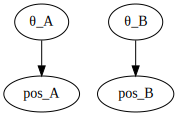

In [1]:
import graphviz
def create_graph():
    dot = graphviz.Digraph(format='png')
    # Define nodes
    dot.node('theta_A', 'θ_A')
    dot.node('theta_B', 'θ_B')
    dot.node('pos_A', 'pos_A')
    dot.node('pos_B', 'pos_B')
    # Define edges
    dot.edge('theta_A', 'pos_A')
    dot.edge('theta_B', 'pos_B')
    return dot
# Display the graph
create_graph()

## Kidney Cancer Data Analysis using PyMC

We analyzed the kidney cancer dataset in Lecture Seven where we did a Bayesian analysis with a Beta prior that was learned from the naive proportions of large counties.

In [17]:
#Read the kidney cancer dataset
import pandas as pd
d_full = pd.read_csv("KidneyCancerClean.csv", skiprows=4)
d = d_full[['state', 'Location', 'fips', 'dc', 'pop', 'dc.2', 'pop.2']].copy()
#Combine the death and population counts for the two periods 80-84 and 85-89
d['dct'] = d['dc'] + d['dc.2'] #dct stands for death count total
d['popm'] = (d['pop'] + d['pop.2']) / 2
print(d.head(20))

      state                   Location  fips  dc     pop  dc.2   pop.2  dct  \
0   ALABAMA    Autauga County, Alabama  1001   2   61921     1   64915    3   
1   ALABAMA    Baldwin County, Alabama  1003   7  170945    15  195253   22   
2   ALABAMA    Barbour County, Alabama  1005   0   33316     1   33987    1   
3   ALABAMA       Bibb County, Alabama  1007   0   30152     1   31175    1   
4   ALABAMA     Blount County, Alabama  1009   3   88342     5   91547    8   
5   ALABAMA    Bullock County, Alabama  1011   0    8313     0    8197    0   
6   ALABAMA     Butler County, Alabama  1013   0   31963     1   31722    1   
7   ALABAMA    Calhoun County, Alabama  1015   9  243105    12  233021   21   
8   ALABAMA   Chambers County, Alabama  1017   7   59985     0   57813    7   
9   ALABAMA   Cherokee County, Alabama  1019   0   43401     0   43828    0   
10  ALABAMA    Chilton County, Alabama  1021   2   65792     3   68837    5   
11  ALABAMA    Choctaw County, Alabama  1023   1   2

In [18]:
#Our specific procedure for obtaining the prior was:
d['naiveproportion'] = d['dct'] / d['popm']
proportions_largecounties = d['naiveproportion'][d['popm'] >= 300000] #filter out the high population counties
m = np.mean(proportions_largecounties)
V = np.var(proportions_largecounties)
a = ((m*m*(1-m))/V) - m
b = (((1-m)*(1-m)*m)/V) - (1-m)
aes = a
bes = b
display(a, b)
d['bayesestimate'] = (d['dct'] + a)/(d['popm'] + a + b)

11.781889938777496

120049.39668603124

After obtaining the prior, we did a standard Bayesian analysis with Binomial likelihood and Beta prior. This part can also be done via PyMC. 

In [19]:
N = d.shape[0] #this is the number of counties
n = np.round(d['popm'].values)
y_obs = d['dct'].values

kidney_model = pm.Model()
with kidney_model:
    theta = pm.Beta("theta", alpha=a, beta=b, shape = N)
    Y = pm.Binomial("Y", n=n, p=theta, observed=y_obs)
    #Sample from posterior:
    idata = pm.sample(1000, chains = 2, return_inferencedata = True) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.7170667963818471, but should be close to 0.8. Try to increase the number of tuning steps.


In [20]:
print(idata.posterior)
#Let us now focus on one of the theta variables (say theta corresponding to the county
#in row 346) and then check if the histogram of posterior samples closely approximate
#the correct posterior Beta density. 
#Posterior samples for theta_346 can be accessed as follows.
theta_346_samples = idata.posterior['theta'][:, :, 346].values.flatten()
print(np.mean(theta_346_samples))
print(len(theta_346_samples))

<xarray.Dataset>
Dimensions:      (chain: 2, draw: 1000, theta_dim_0: 3110)
Coordinates:
  * chain        (chain) int64 0 1
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3 4 5 ... 3105 3106 3107 3108 3109
Data variables:
    theta        (chain, draw, theta_dim_0) float64 4.044e-05 ... 7.283e-05
Attributes:
    created_at:                 2023-09-20T01:41:37.825315
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              25.946101188659668
    tuning_steps:               1000
0.0002029461144040448
2000


state                               FLORIDA
Location           Sarasota County, Florida
fips                                  12115
dc                                       55
pop                                  485595
dc.2                                     65
pop.2                                573711
dct                                     120
popm                               529653.0
naiveproportion                    0.000227
bayesestimate                      0.000203
Name: 346, dtype: object
0.00020283055885838032


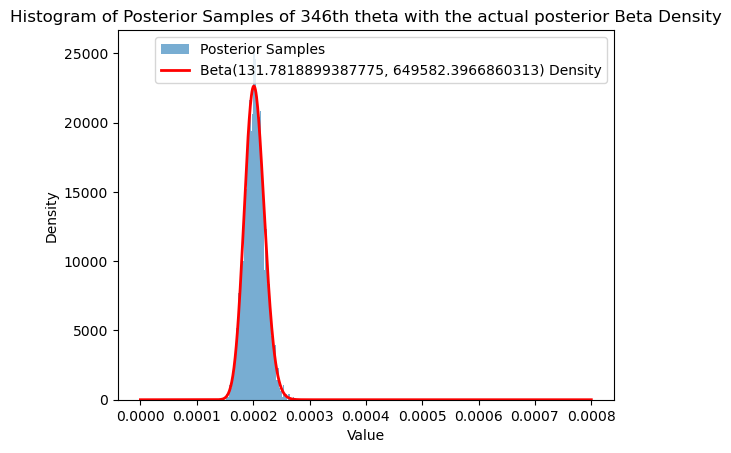

In [21]:
#Let us plot this histogram along with the exact posterior Beta(a + Pos, b + Neg) density:
print(d.iloc[346])
Tot = round(d.loc[346, 'popm'])
Pos = d.loc[346, 'dct']
Neg = Tot - Pos
#This is a large county (population around half a million) and a large death count (120)
#Actual posterior mean
print((a+Pos)/(a+b+Tot))
from scipy.stats import beta
# Plotting histogram
plt.hist(theta_346_samples, bins=50, density=True, alpha=0.6, label="Posterior Samples")

# Superimposing the Beta density
x = np.arange(0, 8e-4, 1e-6)
y = beta.pdf(x, a+Pos, b+Neg)
plt.plot(x, y, 'r-', lw=2, label=f"Beta({a+Pos}, {b+Neg}) Density")
# Labels, legend, and title
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.title("Histogram of Posterior Samples of 346th theta with the actual posterior Beta Density")
plt.show()

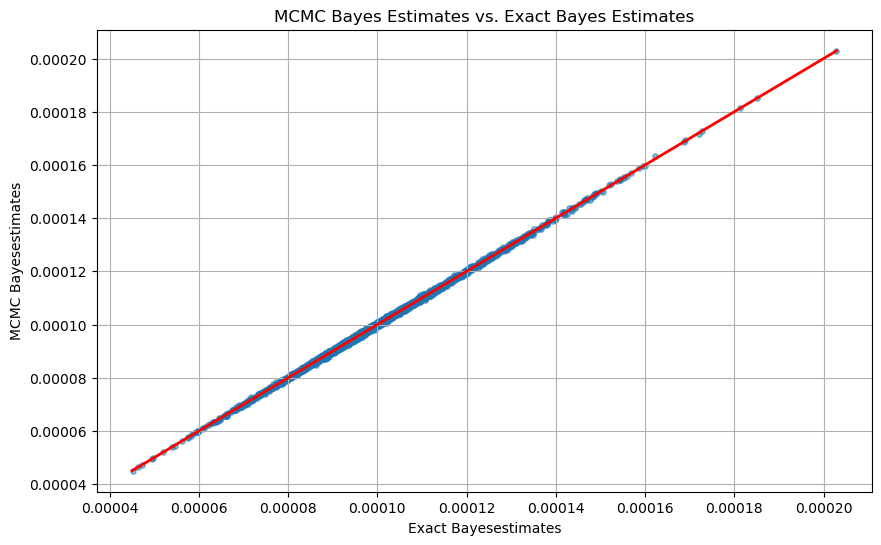

In [22]:
#We can compute the posterior means for all theta parameters by simply averaging
#the observed posterior samples
theta_samples = idata.posterior['theta'].values
combined_samples = theta_samples.reshape(-1, N)
theta_means = np.mean(combined_samples, axis=0)

#We can check if these Bayes estimates obtained from samples generated by 
#some kind of a Markov Chain Monte Carlo (MCMC) algorithm match the Bayes estimates
#calculated from the correct Beta posterior densities

#Plot theta_means against the exact posterior mean Bayes estimates
plt.figure(figsize=(10, 6))
plt.scatter(d['bayesestimate'].values, theta_means, alpha=0.5, s = 15)

# Add the y=x line
min_val = min(d['bayesestimate'].values.min(), theta_means.min())
max_val = max(d['bayesestimate'].values.max(), theta_means.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r-', lw=2, label="y=x line")

plt.xlabel("Exact Bayesestimates")
plt.ylabel("MCMC Bayesestimates")
plt.title("MCMC Bayes Estimates vs. Exact Bayes Estimates")
plt.grid(True)
plt.show()
#Clearly the two methods give very nearly the same answers

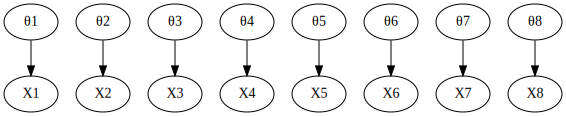

In [23]:
#The graphical model here is very simple: 
from graphviz import Digraph

def create_graphical_model(N):
    # Create a new directed graph
    dot = Digraph()

    # Add theta nodes and X nodes
    theta_nodes = [f"theta_{i}" for i in range(1, N+1)]
    X_nodes = [f"X_{i}" for i in range(1, N+1)]
    for i in range(N):
        dot.node(theta_nodes[i], label=f"θ{i+1}")
        dot.node(X_nodes[i], label=f"X{i+1}")
        dot.edge(theta_nodes[i], X_nodes[i])
    return dot

# Display the graph
display(create_graphical_model(8))

# Analysis via a Hierarchical Model

In the above analysis, $a$ and $b$ are estimated from the given data on the proportions for large counties. Large was taken to mean population more than 300000. Of course if we use another definition of large, we will get different (but hopefully similar) results. One way of avoiding such ad-hoc estimation is to incorporate $a$ and $b$ also as unknown parameters in the PyMC model. This can be done in the following way: 

In [24]:
kidney_model_ab_unknown = pm.Model()
with kidney_model_ab_unknown:
    a = pm.Uniform('a', lower = 0, upper = 50)
    b = pm.Uniform('b', lower = 0, upper = 200000)
    theta = pm.Beta("theta", alpha=a, beta=b, shape = N)
    Y = pm.Binomial("Y", n=n, p=theta, observed=y_obs)
    #Sample from posterior:
    idata = pm.sample(1000, chains = 2, return_inferencedata = True) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 105 seconds.
There were 347 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6992742015685093, but should be close to 0.8. Try to increase the number of tuning steps.
There were 660 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6116679458637905, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


This approach produces posterior samples for $a$ and $b$ (in addition to the $\theta$ parameters). One can use these samples to obtain point estimates for $a$ and $b$, and also to characterize uncertainty in $a$ and $b$. 

In [25]:
a_samples = idata.posterior['a'].values.flatten()
b_samples = idata.posterior['b'].values.flatten()
amean = np.mean(a_samples)
astd = np.std(a_samples)
bmean = np.mean(b_samples)
bstd = np.std(b_samples)
display([amean, astd])
display([bmean, bstd])

[17.068281999244608, 1.1274766547362032]

[164737.25252111058, 11262.339137284955]

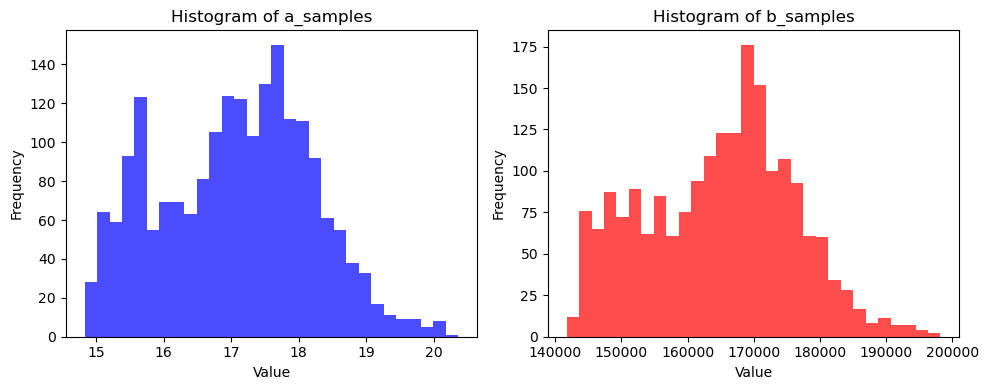

In [26]:
#plotting the histograms of a_samples and b_samples
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].hist(a_samples, bins=30, color='blue', alpha=0.7, label='a_samples')
axes[0].set_title('Histogram of a_samples')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[1].hist(b_samples, bins=30, color='red', alpha=0.7, label='b_samples')
axes[1].set_title('Histogram of b_samples')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

0.00019285921452520883
2000
0.00020283055885838032


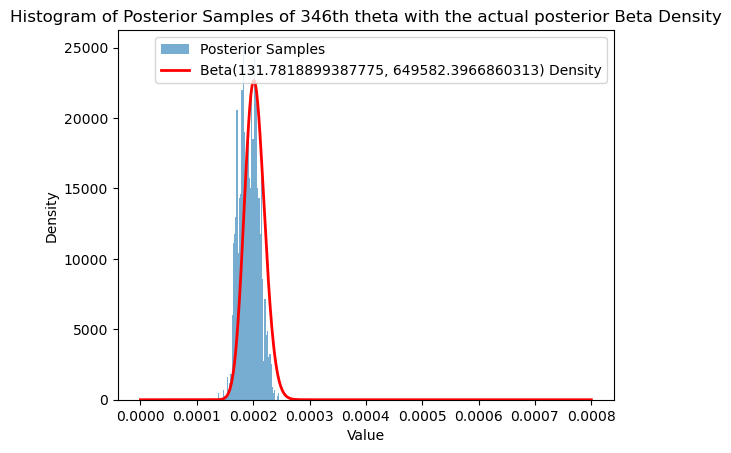

In [31]:
#Let us investigate the theta samples:
#As before, we can look at the histogram of the posterior samples for theta_346 and
#compare it with the Beta posterior from the previous analysis
theta_346_samples = idata.posterior['theta'][:, :, 346].values.flatten()
print(np.mean(theta_346_samples))
print(len(theta_346_samples))

#Let us plot this histogram along with Beta(a + Pos, b + Neg) posterior for our previous values of a and b
Tot = round(d.loc[346, 'popm'])
Pos = d.loc[346, 'dct']
Neg = Tot - Pos
#This is a large county (population around half a million) and a large death count (120)
#Actual posterior mean
print((aes+Pos)/(aes+bes+Tot))
from scipy.stats import beta
# Plotting histogram
plt.hist(theta_346_samples, bins=50, density=True, alpha=0.6, label="Posterior Samples")

# Superimposing the Beta density
x = np.arange(0, 8e-4, 1e-6)
y = beta.pdf(x, aes+Pos, bes+Neg)
plt.plot(x, y, 'r-', lw=2, label=f"Beta({aes+Pos}, {bes+Neg}) Density")
# Labels, legend, and title
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.title("Histogram of Posterior Samples of 346th theta with the actual posterior Beta Density")
plt.show()

#This is similar to our previous result but the histogram has moved slightly to the left. 

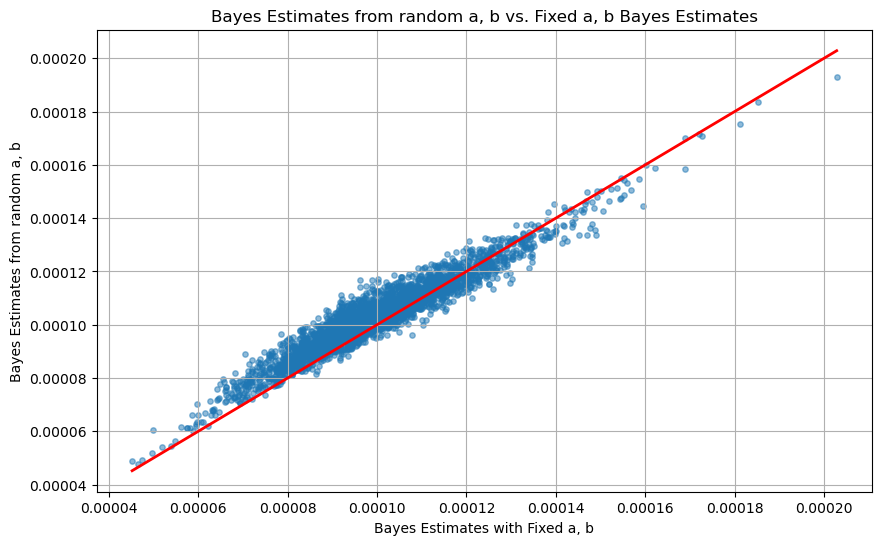

In [28]:
#We now compare the Bayes estimates in this random a, b model with 
#the Bayes estimates based on estimation of a, b in our previous adhoc way.
theta_samples = idata.posterior['theta'].values
combined_samples = theta_samples.reshape(-1, N)
theta_means = np.mean(combined_samples, axis = 0)

#Plot theta_means against the exact posterior mean Bayes estimates
plt.figure(figsize=(10, 6))
plt.scatter(d['bayesestimate'].values, theta_means, alpha=0.5, s = 15)

# Add the y=x line
min_val = min(d['bayesestimate'].values.min(), theta_means.min())
max_val = max(d['bayesestimate'].values.max(), theta_means.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r-', lw=2, label="y=x line")

plt.xlabel("Bayes Estimates with Fixed a, b")
plt.ylabel("Bayes Estimates from random a, b")
plt.title("Bayes Estimates from random a, b vs. Fixed a, b Bayes Estimates")
plt.grid(True)
plt.show()

#The results are similar but there are some differences. 

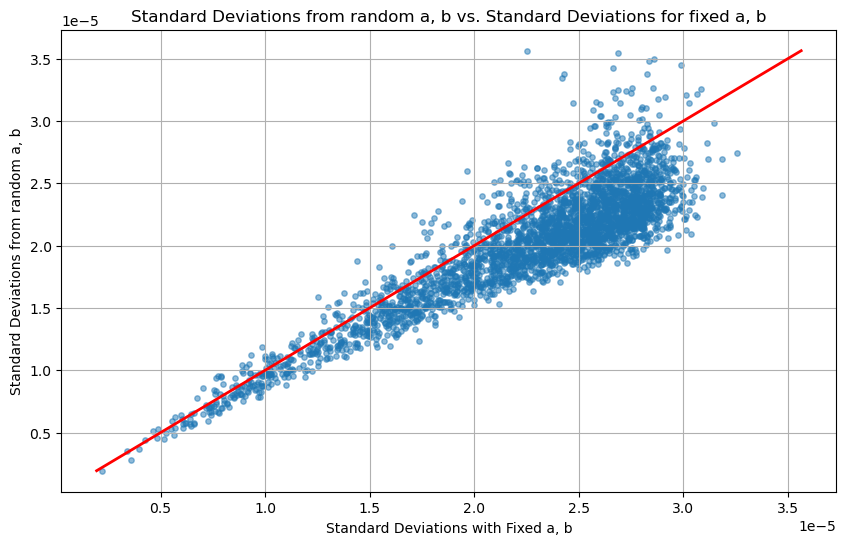

In [32]:
#Plotting the posterior standard deviations
theta_stddevs = np.std(combined_samples, axis = 0)

d['bayesstddev'] = np.sqrt(((d['dct'] + aes)/(d['popm'] + aes + bes)) * (1 - ((d['dct'] + aes)/(d['popm'] + aes + bes))) * (1/(d['popm'] + aes + bes + 1)))
#Plot theta_means against the exact posterior mean Bayes estimates
plt.figure(figsize=(10, 6))
plt.scatter(d['bayesstddev'].values, theta_stddevs, alpha=0.5, s = 15)

# Add the y=x line
min_val = min(d['bayesstddev'].values.min(), theta_stddevs.min())
max_val = max(d['bayesstddev'].values.max(), theta_stddevs.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r-', lw=2, label="y=x line")

plt.xlabel("Standard Deviations with Fixed a, b")
plt.ylabel("Standard Deviations from random a, b")
plt.title("Standard Deviations from random a, b vs. Standard Deviations for fixed a, b")
plt.grid(True)
plt.show()
#From this plot, it is clear that the standard deviations in this random a, b model are
#generally smaller than the standard deviations in the fixed a, b model. 
#It appears that this Bayesian Hierarchical Model is able to deduce more information
#about the theta parameters (leading to slightly smaller uncertainty) compared to the
#method where we estimated a and b using only about 300 large counties. 

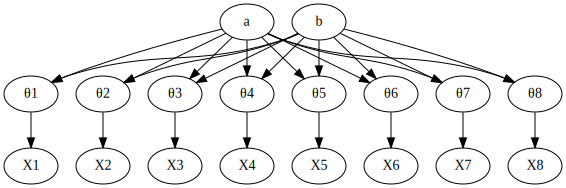

In [30]:
#The graphical model for this model is the following:
from graphviz import Digraph

def create_graphical_model(N):
    # Create a new directed graph
    dot = Digraph()

    # Add theta nodes and X nodes
    theta_nodes = [f"theta_{i}" for i in range(1, N+1)]
    X_nodes = [f"X_{i}" for i in range(1, N+1)]
    for i in range(N):
        dot.node(theta_nodes[i], label=f"θ{i+1}")
        dot.node(X_nodes[i], label=f"X{i+1}")
        dot.edge(theta_nodes[i], X_nodes[i])

    # Add nodes a and b
    dot.node("a", "a")
    dot.node("b", "b")

    # Add directed edges from a and b to each theta_i
    for theta in theta_nodes:
        dot.edge("a", theta)
        dot.edge("b", theta)

    return dot

# Display the graph
display(create_graphical_model(8))

The above is an example of a **Bayesian Hierarchical Model**. $a$ and $b$ are referred to as hyperparameters (to distinguish them from the parameters $\theta_1, \dots, \theta_N$). In the next class, we shall study more Bayesian models and use them for data analysis through PyMC. 